In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path

folder = "AI_Programming/cnn"
project_dir = "hw5_dataset"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/AI_Programming/cnn/hw5_dataset


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tensorflow version: 2.9.2
GPU 사용 가능 여부: False


In [ ]:
data_dir = '/content/drive/My Drive/AI_Programming/cnn/hw5_dataset'

In [ ]:
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 224

PATH = data_dir

In [ ]:
def load(image_file, label):

    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

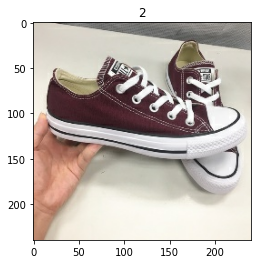

In [ ]:
image, label = load(os.path.join(PATH, 'train/converse/38.jpg'), 2)
# casting to int for matplotlib to show the image
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

In [ ]:
def resize(input_image, height, width):

    input_image = tf.image.resize(input_image, [height, width])

    return input_image

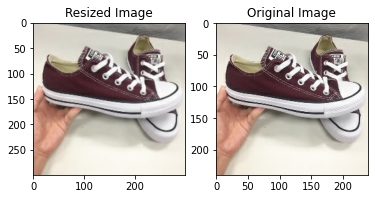

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def random_rotation(input_image):
    
    angles = np.random.randint(0,4)
    rotated_image = tf.image.rot90(input_image, angles)
  
    return rotated_image

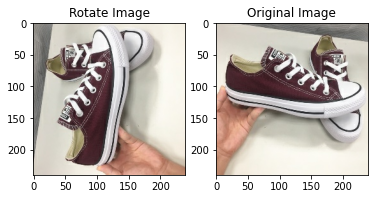

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def random_crop(input_image):

    cropped_image = tf.image.random_crop(value=input_image, size=(224, 224, 3))
    
    return cropped_image

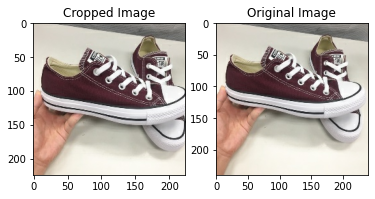

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def normalize(input_image):

    # input_image = input_image.astype('float64')
    input_image = input_image / 255

    return input_image

In [ ]:
def random_jitter(input_image):

    input_image = resize(input_image, 224, 224)
    input_image = random_crop(input_image)
    input_image = random_rotation(input_image)  
    input_image = tf.image.random_flip_left_right(input_image)

    return input_image

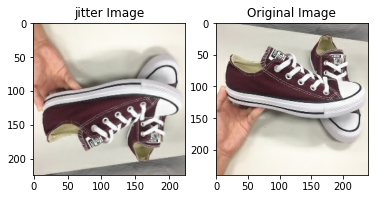

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def central_crop(input_image):

    input_image = resize(input_image, 250, 250)
    input_image = tf.image.central_crop(input_image, central_fraction=0.896)
    
    return input_image

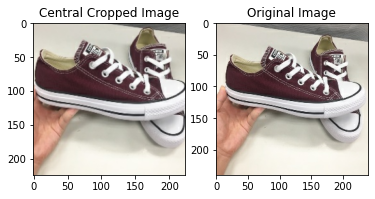

In [ ]:
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [ ]:
def load_image_train(image_file, label):

    input_image, label = load(image_file, label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [ ]:
def load_image_val_and_test(image_file, label):

    input_image, label = load(image_file, label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [ ]:
def add_label(image_file, label):
    return image_file, label

In [ ]:
folder_list_train = [f for f in os.listdir(os.path.join(PATH, 'train')) if not f.startswith('.')]

In [ ]:
folder_list_train[0]

'converse'

In [ ]:
folder_list_train[1]

'adidas'

In [ ]:
folder_list_train[2]

'nike'

In [ ]:
train_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'train', folder_list_train[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 1))

temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'train', folder_list_train[1], '*.jpg'))
temp_dataset = temp_dataset.map(lambda x: add_label(x, 0))
train_dataset = train_dataset.concatenate(temp_dataset)

temp1_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'train', folder_list_train[2], '*.jpg'))
temp1_dataset = temp1_dataset.map(lambda x: add_label(x, 2))
train_dataset = train_dataset.concatenate(temp1_dataset)

In [ ]:
N = BUFFER_SIZE = len(list(train_dataset))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls = 16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [ ]:
folder_list_val = [f for f in os.listdir(os.path.join(PATH, 'validation')) if not f.startswith('.')]

In [ ]:
folder_list_val[0]

'nike'

In [ ]:
folder_list_val[1]

'converse'

In [ ]:
folder_list_val[2]

'adidas'

In [ ]:
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'validation', folder_list_val[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 2))

temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'validation', folder_list_val[1], '*.jpeg'))
temp_dataset = temp_dataset.map(lambda x: add_label(x, 1))
val_dataset = val_dataset.concatenate(temp_dataset)

temp1_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'validation', folder_list_val[2], '*.jpg'))
temp1_dataset = temp1_dataset.map(lambda x: add_label(x, 0))
val_dataset = val_dataset.concatenate(temp1_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [ ]:
folder_list_test = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]

In [ ]:
folder_list_test[0]

'converse'

In [ ]:
folder_list_test[1]

'adidas'

In [ ]:
folder_list_test[2]

'nike'

In [ ]:
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list_test[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 1))

temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list_test[1], '*.jpg'))
temp_dataset = temp_dataset.map(lambda x: add_label(x, 0))
test_dataset = test_dataset.concatenate(temp_dataset)

temp1_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list_test[2], '*.jpg'))
temp1_dataset = temp1_dataset.map(lambda x: add_label(x, 2))
test_dataset = test_dataset.concatenate(temp1_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

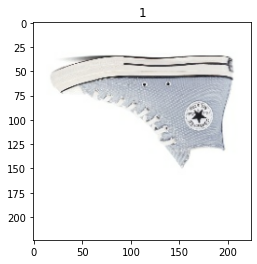

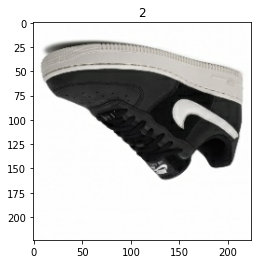

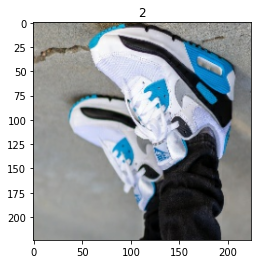

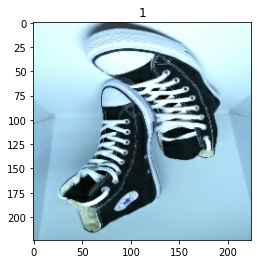

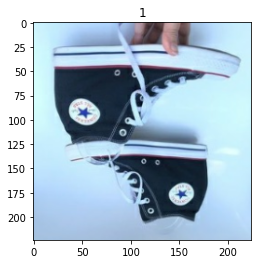

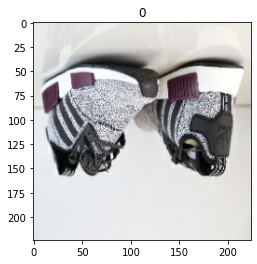

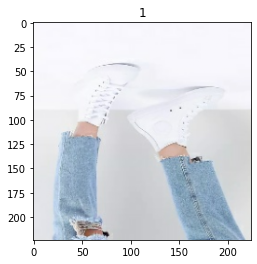

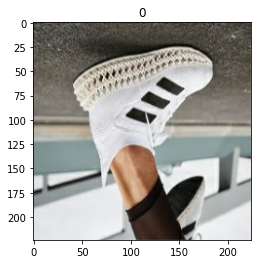

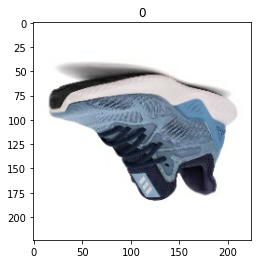

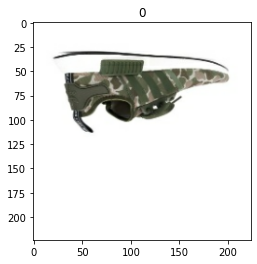

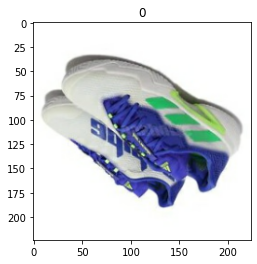

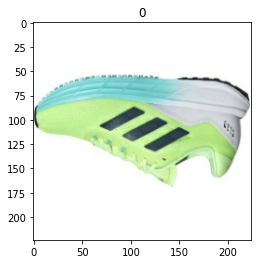

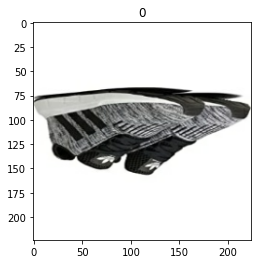

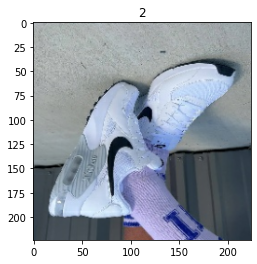

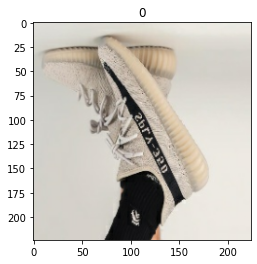

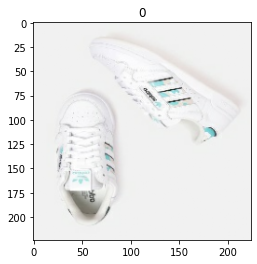

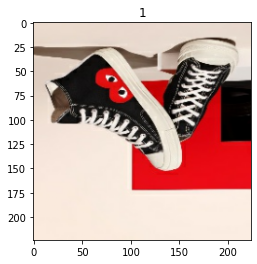

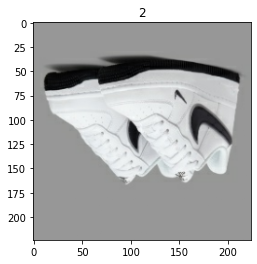

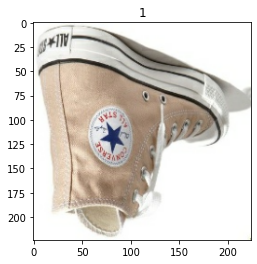

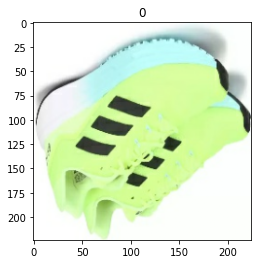

In [ ]:
for images, labels in train_dataset.take(1):
    for j in range(20):
        plt.figure()
        plt.imshow(images[j])
        plt.title(labels[j].numpy())
        plt.show()

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(3, kernel_size=(3,3), strides = (2, 2), input_shape = (224, 224, 3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1, 1), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (2, 2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (2, 2), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model(images[:1])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.32713443, 0.3765837 , 0.29628196]], dtype=float32)>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 111, 3)       84        
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 3)      12        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 111, 111, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 109, 109, 64)      0

In [ ]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_freq='epoch',  verbose=1)

In [ ]:
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = 'accuracy')

In [ ]:
train_len = len(glob(os.path.join(PATH, 'train', folder_list_train[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list_val[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list_test[0], '*.jpg'))) * 2

In [ ]:
train_len

474

In [ ]:
model.fit(train_dataset, steps_per_epoch = train_len/batch_size,
          validation_data = val_dataset, 
          validation_steps = 1,
         epochs= max_epochs,
         callbacks= [cp_callback])

Epoch 1/20
24/23 [==============================] - ETA: 0s - loss: 2.7443 - accuracy: 0.3313

InvalidArgumentError: ignored